In [26]:
# # copy the weights and configurations for the pre-trained models
# !mkdir ~/.keras
# !mkdir ~/.keras/models
# !cp ./Data/keras-pretrained-models/*notop* ~/.keras/models/
# !cp ./Data/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

The syntax of the command is incorrect.
The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
UsageError: Line magic function `%cp` not found.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
import glob
%matplotlib inline

In [9]:
base_image_dir = os.path.join('.', 'Data', 'train')
retina_df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

0 images found of 53576 total


ValueError: a must be greater than 0 unless no samples are taken

Examine the distribution of eye and severity

array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

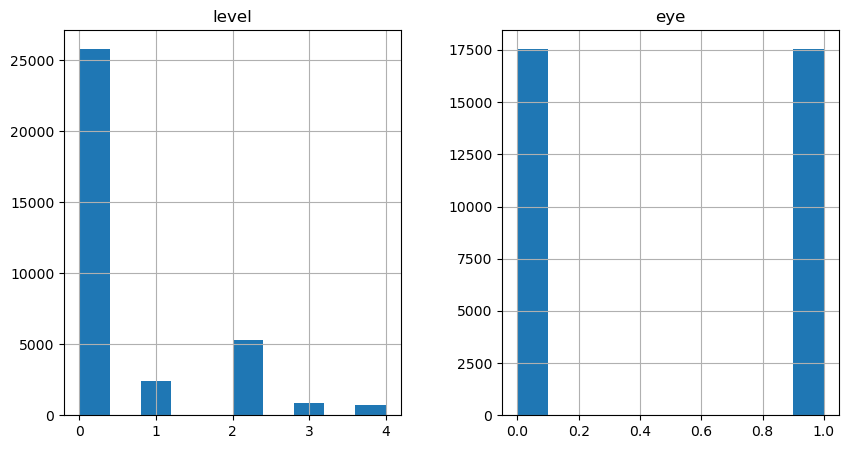

In [3]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

Split Data into Training and Validation

In [4]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'],
                                        test_size = 0.25,
                                        random_state = 2018,
                                        stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 27176 validation 9632


Balance the distribution in the training set

New Data Size: 750 Old Size: 27176


array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

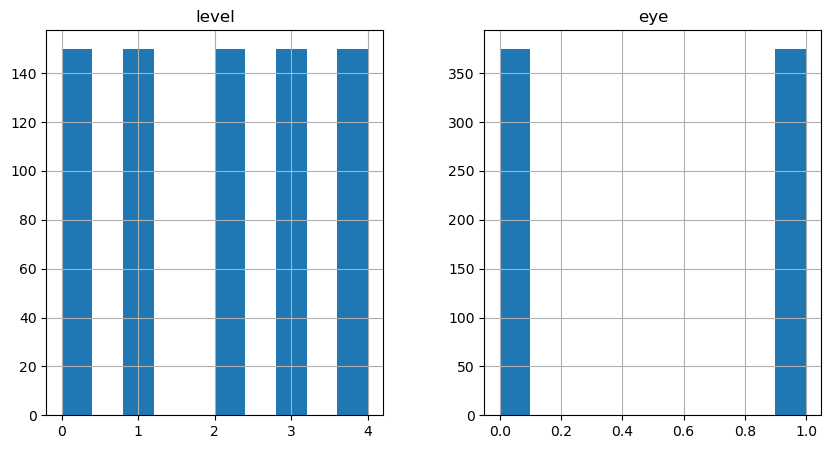

In [5]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [7]:
import tensorflow as tf
import tensorflow_addons as tfa
import keras.backend as kb
from keras.applications.inception_v3 import preprocess_input

IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects

In [8]:
def tf_image_loader(out_size,
                    horizontal_flip = True,
                    vertical_flip = False,
                    random_brightness = True,
                    random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                    color_mode = 'rgb',
                    preproc_func = preprocess_input,
                    on_batch = False):

    def func(x):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('Data'):
                x = tf.image.decode_png(tf.io.read_file(x), channels = 3 if color_mode == 'rgb' else 0)
                x = tf.image.resize(x, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    x = tf.image.random_flip_left_right(x)
                if vertical_flip:
                    x = tf.image.random_flip_up_down(x)
                if random_brightness:
                    x = tf.image.random_brightness(x, max_delta = 0.1)
                if random_saturation:
                    x = tf.image.random_saturation(x, lower = 0.75, upper = 1.5)
                if random_hue:
                    x = tf.image.random_hue(x, max_delta = 0.15)
                if random_contrast:
                    x = tf.image.random_contrast(x, lower = 0.75, upper = 1.5)
                return preproc_func(x)

    if on_batch:
        # we are meant to use it on a batch
        def batch_func(x, y):
            return tf.map_fn(func, x), y
        return batch_func
    else:
        # we apply it to everything
        def all_func(x, y):
            return func(x), y
        return all_func

In [9]:
def tf_augmentor(out_size,
                 intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                 horizontal_flip = True,
                 vertical_flip = False,
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                 random_hue = True,
                 color_mode = 'rgb',
                 preproc_func = preprocess_input,
                 min_crop_percent = 0.001,
                 max_crop_percent = 0.005,
                 crop_probability = 0.5,
                 rotation_range = 10):

    load_ops = tf_image_loader(out_size = intermediate_size,
                               horizontal_flip=horizontal_flip,
                               vertical_flip=vertical_flip,
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)

    def batch_ops(x, y):
        batch_size = tf.shape(x)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random.uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tfa.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random.uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random.uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random.uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                    crop_pct,
                    tf.zeros([batch_size]), top,
                    tf.zeros([batch_size]), crop_pct, left,
                    tf.zeros([batch_size]),
                    tf.zeros([batch_size])
                ], 1)
                coin = tf.less(tf.random.uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                x = tfa.image.transform(x,
                                        tfa.image.compose_transforms(*transforms),
                                        interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                x = tf.image.resize(x, out_size)
            elif intermediate_trans=='crop':
                x = tf.image.crop_and_resize(x, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return x, y

    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)

    return _create_pipeline

In [10]:
def flow_from_dataframe(idg,
                        in_df,
                        path_col,
                        y_col,
                        shuffle = True,
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset

        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            yield kb.get_session().run(next_batch)

In [20]:
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE,
                        batch_size = batch_size,
                        vertical_flip = True,
                        color_mode = 'rgb',
                        crop_probability=0.0) # crop doesn't work yet
print(core_idg)

valid_idg = tf_augmentor(out_size = IMG_SIZE,
                         batch_size = batch_size,
                         horizontal_flip = False,
                         vertical_flip = False,
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         color_mode = 'rgb',
                         crop_probability=0.0,
                         rotation_range = 0)
print(valid_idg)

train_gen = flow_from_dataframe(core_idg, train_df,
                                path_col = 'path',
                                y_col = 'level_cat')
print(train_gen)

valid_gen = flow_from_dataframe(valid_idg, valid_df,
                                path_col = 'path',
                                y_col = 'level_cat') # we can use much larger batches for evaluation
print(valid_gen)


<function tf_augmentor.<locals>._create_pipeline at 0x0000028DD8161000>
<function tf_augmentor.<locals>._create_pipeline at 0x0000028DD81600D0>
<generator object flow_from_dataframe at 0x0000028DD81B5690>
<generator object flow_from_dataframe at 0x0000028DD81B61F0>


Validation Set

In [21]:
t_x, t_y = next(valid_gen)
print(t_x, t_y)

fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

TypeError: in user code:

    File "C:\Users\ronaz\AppData\Local\Temp\ipykernel_43400\1836725352.py", line 62, in batch_ops  *
        x = tf.image.crop_and_resize(x, out_size[0], out_size[1])

    TypeError: Missing required positional argument


Training Set

In [22]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

OperatorNotAllowedInGraphError: in user code:

    File "C:\Users\ronaz\AppData\Local\Temp\ipykernel_43400\1836725352.py", line 56, in batch_ops  *
        x = tfa.image.transform(x,
    File "C:\Users\ronaz\anaconda3\envs\anaconda\lib\site-packages\tensorflow_addons\image\transform_ops.py", line 152, in compose_transforms  *
        assert transforms, "transforms cannot be empty"

    OperatorNotAllowedInGraphError: Using a symbolic `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.


Attention Model

In [17]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1,
                    kernel_size = (1,1),
                    padding = 'valid',
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same',
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                     metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

NameError: name 't_x' is not defined

In [18]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]